# 04. Pytorch custom datasets

Getting your own dataset to pytorch and solving your problem set

and look at pytorch domain libaries depending on what your working on.

## 0. Importing Pytorch and setup device agnostic code

In [1]:
# import pytorch
import torch
torch.__version__

'2.4.0+cu124'

In [2]:
# device agnostic code
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# check gpu if available
!nvidia-smi

Sat Sep 14 13:29:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P0             N/A / ERR!  |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data

our dataset is a subset of food101 dataset, which is only 3 classes and only 10% of the images.



In [4]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / 'pizza_steak_sushi'

# if the image folder doesn't exist, download and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory sudah ada, skipping download')
else:
    print(f'{image_path} tidak ada, mulai download')
    image_path.mkdir(parents=True, exist_ok=True)
    
# download the dataset from mrdbourke github
with open(data_path / 'pizza_steak_sushi.zip', mode="wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloading dataset')
    f.write(requests.content)
    
# unzip dataset
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping dataset')
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory sudah ada, skipping download
Unzipping dataset


## 2. Data preparation and data exploration

In [5]:
import os 
from helper_functions import walk_through_dir

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [7]:
# setup training and testing path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

### 2.1 Visualizing random images

tulis code untuk:
1. get all image path
2. pick a random image using python random
3. get image class name using `pathlib.Path.parent.stem`
4. open the image using python PIL(pillow)
5. show the image and print metadata

Random Image Path: data\pizza_steak_sushi\train\steak\1615395.jpg
Image Class: steak
Image Height: 384
Image Width: 512


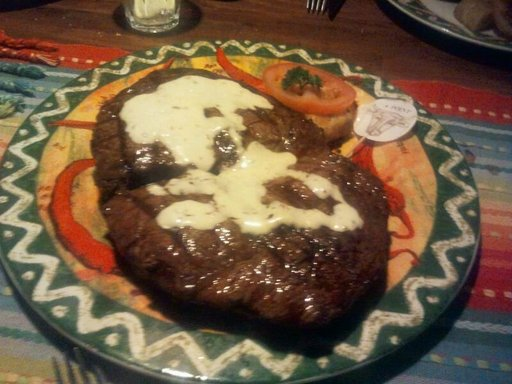

In [8]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)

# 3. get the image class from pathname
image_class =  random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random Image Path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

In [9]:
import matplotlib.pyplot as plt

In [10]:
# # try to visualize image with matplotlib
# import random
# from PIL import Image

# # set seed
# # random.seed(42)

# # 1. get all image path
# image_path_list = list(image_path.glob("*/*/*.jpg"))

# # 2. Create a 3x3 grid
# fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# # Loop to fill the grid with images
# for i in range(3):
#     for j in range(3):
#         # Pick a random image path
#         random_image_path = random.choice(image_path_list)
        
#         # Get the image class from the pathname
#         image_class = random_image_path.parent.stem
        
#         # Open image using matplotlib
#         img = plt.imread(random_image_path)
        
#         # Display the image in the corresponding subplot
#         axs[i, j].imshow(img)
#         axs[i, j].axis('off')  # Hide axes
        
#         # Set the label as the title of the subplot
#         axs[i, j].set_title(image_class)

# # Adjust layout
# plt.tight_layout()
# plt.show()

(-0.5, 511.5, 383.5, -0.5)

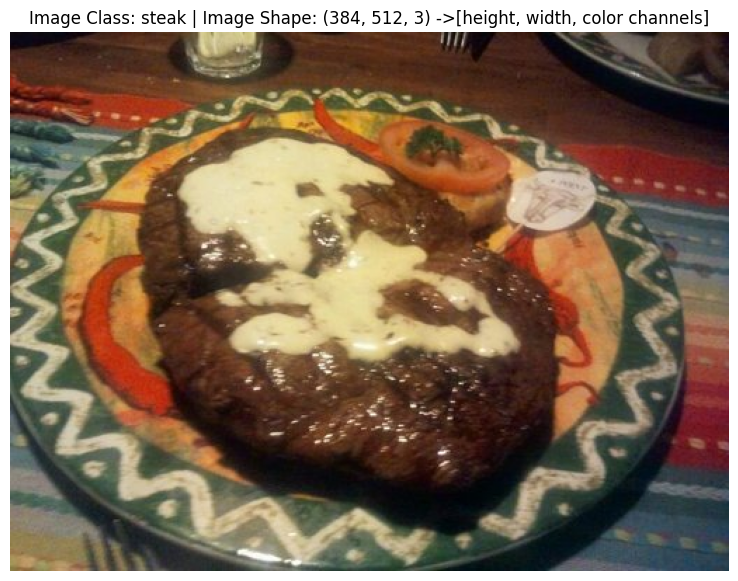

In [11]:
# daniel version
import numpy as np
import matplotlib.pyplot as plt

# turn the image into array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image Class: {image_class} | Image Shape: {img_as_array.shape} ->[height, width, color channels]')
plt.axis(False)

## 3. Turning image into pytorch

getting the image into tensor format.

before we can use our image data with pytorch:
1. turn your target data into tensors
2. turn it into a `torch.utils.data.Dataset` and into a `torch.utils.data.DataLoader`.


In [27]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms.v2 as transforms

torchvision.__version__

'0.19.0+cu124'

### 3.1 Transforming data with torchvision transforms

In [13]:
# write a transform for image
data_transform = transforms.Compose([
    # resize image to 64x64
    transforms.Resize(size=(64, 64)),
    # flip the images horizontal randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # flip the images vertical randomly
    transforms.RandomVerticalFlip(p=0.5),
    # rotates the image randomly
    transforms.RandomRotation(degrees=30),
    # turn the image into torch.tensor
    transforms.ToImage(),
    # transforms.ToTensor() # deprecated
    # transforms.PILToTensor(),
    # transforms.ToDtype(torch.float32, scale=True)
])

In [14]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

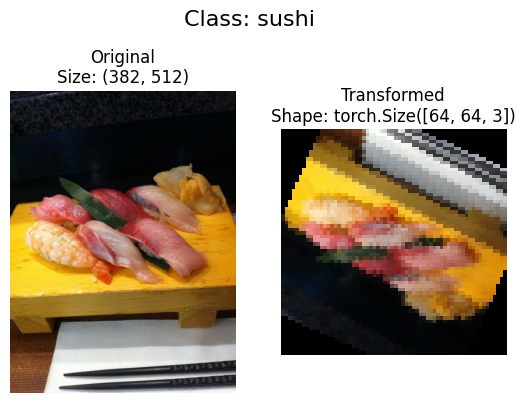

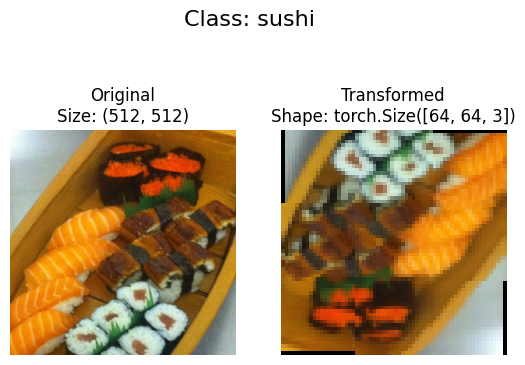

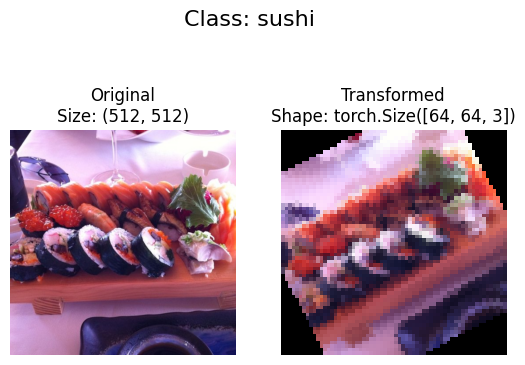

In [15]:
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `Image Folder`

load image classification data using `torchvision.datasets.ImageFolder`

In [16]:
# use ImageFolder to create datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  RandomVerticalFlip(p=0.5)
                  RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                  ToImage()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  RandomVerticalFlip(p=0.5)
                  RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                  ToImage()
            ))

In [17]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [18]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [21]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [22]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 Image([[[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]],

       [[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]],

       [[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8, )
Image shape: torch.Size([3, 64, 64])
Image datatype: torch.uint8
Image label: 0
Label datatype: <class 'int'>


*Note*:
- kalo pake transform `ToImage()`, image datatypenya jadi `uint8`
- kalo pake transform `ToTensor()`, image datatypenya tetep `float32` namun ini bakalan deprecated, jadi ya pake `ToImage()` aja

Original Shape: torch.Size([3, 64, 64]) -> [color, height, width]
Permuted Image: torch.Size([64, 64, 3]) -> [height, width, color]


Text(0.5, 1.0, 'pizza')

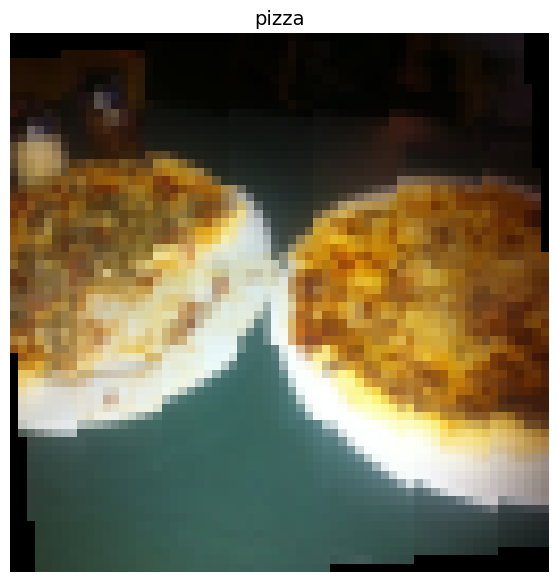

In [23]:
# rearrange order of dimensions
img_permute = img.permute(1,2,0)

# print out different shapes
print(f'Original Shape: {img.shape} -> [color, height, width]')
print(f'Permuted Image: {img_permute.shape} -> [height, width, color]')

# plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

## 4.1. Turn loaded images into `Dataloader`'s

dataloader is going to be used to load data in batches and we can set the batch size to any number we want. for example we can set it to 8.

In [24]:
len(train_data), len(test_data)

(225, 75)

In [26]:
225 / 8

28.125

In [51]:
# turn train and test datasets into dataloader
# set batches
BATCH_SIZE = 8

# create a CPU_WORKER Hyperparameter
CPU_WORKER = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=CPU_WORKER,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=CPU_WORKER,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x13f105be560>,
 <torch.utils.data.dataloader.DataLoader at 0x13f105bf640>)

In [52]:
len(train_dataloader), len(test_dataloader)

(29, 10)

In [53]:
# check the shape of an image from dataloader
img, label = next(iter(train_dataloader))
print(f'Image Shape: {img.shape} -> [Batch Size, Color, Height, Width]')
print(f'Label Shape {label.shape}')

Image Shape: torch.Size([8, 3, 64, 64]) -> [Batch Size, Color, Height, Width]
Label Shape torch.Size([8])


## 5. Option 2: Loading image data with a custom dataset

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:

* Can create a Dataset out of almost anything
* Not limited to PyTorch pre-built Dataset functions

Cons:

* Even though you could create Dataset out of almost anything, it doesn't mean it will work...
* Using a custom Dataset often results in us writing more code, which could be prone to errors or performance issues

In [54]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [57]:
# Instance of torchvision.datasets.ImageFolder()
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names
We want a function to:

* Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
* Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
* Turn the class names into a dict and a list and return them.


*note*: i'm skipping this

more on this : https://nbviewer.org/github/mrdbourke/pytorch-deep-learning/blob/main/video_notebooks/04_pytorch_custom_datasets_video.ipynb#

In [60]:
# # Setup path for target directory
# target_directory = train_dir
# print(f"Target dir: {target_directory}")

# # Get the class names from the target directory 
# class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
# class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [61]:
# list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [ ]:
# def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
#   """Finds the class folder names in a target directory."""
#   # 1. Get the class names by scanning the target directory
#   classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

#   # 2. Raise an error if class names could not be found
#   if not classes:
#     raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

#   # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
#   class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
#   return classes, class_to_idx

In [62]:
# course progress
146 / 358 * 100

40.78212290502793

### 5.2 Create a custom Dataset to replicate ImageFolder

uncomment for trying, i'm skipping this

more on this: https://nbviewer.org/github/mrdbourke/pytorch-deep-learning/blob/main/video_notebooks/04_pytorch_custom_datasets_video.ipynb#

In [ ]:
# # 0. Write a custom dataset class
# from torch.utils.data import Dataset

# # 1. Subclass torch.utils.data.Dataset
# class ImageFolderCustom(Dataset):
#   # 2. Initialize our custom dataset
#   def __init__(self, 
#                targ_dir: str, 
#                transform=None):
#     # 3. Create class attributes
#     # Get all of the image paths
#     self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
#     # Setup transform
#     self.transform = transform
#     # Create classes and class_to_idx attributes
#     self.classes, self.class_to_idx = find_classes(targ_dir)

#   # 4. Create a function to load images
#   def load_image(self, index: int) -> Image.Image:
#     "Opens an image via a path and returns it."
#     image_path = self.paths[index]
#     return Image.open(image_path)

#   # 5. Overwrite __len__()
#   def __len__(self) -> int:
#     "Returns the total number of samples."
#     return len(self.paths)
  
#   # 6. Overwrite __getitem__() method to return a particular sample
#   def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
#     "Returns one sample of data, data and label (X, y)."
#     img = self.load_image(index)
#     class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
#     class_idx = self.class_to_idx[class_name]

#     # Transform if necessary
#     if self.transform:
#       return self.transform(img), class_idx # return data, label (X, y)
#     else:
#       return img, class_idx # return untransformed image and label


In [ ]:
# img, label = train_data[0]

In [ ]:
# img, label

In [63]:
# # Create a transform
# from torchvision import transforms
# train_transforms = transforms.Compose([
#                                       transforms.Resize(size=(64, 64)),
#                                       transforms.RandomHorizontalFlip(p=0.5),
#                                       transforms.ToTensor() 
# ])

# test_transforms = transforms.Compose([
#                                       transforms.Resize(size=(64, 64)),
#                                       transforms.ToTensor()
# ])

In [ ]:
# # Test out ImageFolderCustom
# train_data_custom = ImageFolderCustom(targ_dir=train_dir,
#                                       transform=train_transforms)

# test_data_custom = ImageFolderCustom(targ_dir=test_dir,
#                                      transform=test_transforms)

In [ ]:
# train_data_custom, test_data_custom

In [ ]:
# len(train_data), len(train_data_custom)

In [ ]:
# len(test_data), len(test_data_custom)

In [ ]:
# train_data_custom.classes

In [ ]:
# train_data_custom.class_to_idx

In [ ]:
# # Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
# print(train_data_custom.classes==train_data.classes)
# print(test_data_custom.classes==test_data.classes)